# A gaussian integral

Using Monte Carlo integration, check that

$$ \int_0^\infty x^3 \exp\left(-\frac{x^2}{2\sigma^2}\right) \,dx = 2\sigma^4 .$$

- Does the result converge with the number of samples? And how does the error go down?
- Do it many times. For a given $N$, how are the result distributed? We'll talk about model fitting at lenght later on, but for now try to fit it by hand with a parametrized model. (If N is large enough you should get something that looks *very* accurate! And if $N$ is small?)
- How does the distribution change if $N$ increases?

(Hint: think about sample mean and sample variance)

## Monte Carlo integration

You might have seen this already, but Monte Carlo integration is an absolute crucial notion in modern statistics (modern because it relies on generating a large number of data points, which has been made possible by computers). Suppose you have very a complicated integral to solve and that you can write down the integrand as a product of $f(x)$ and $p(x)$ with $\int p(x)=1$ (this is not restrictive at all! See below). My nasty integral is

$$\int f(x) p(x) dx$$


Provided one can **evaluate** $f(x)$ and **sample** $p(x)$, then


$$\int f(x) p(x) dx \approx \frac{1}{N}\sum_{i=1}^N f(x_i) $$

where $x_i$ are samples drawn from $p$. 








In [2]:
import numpy as np
from scipy.stats import norm
from scipy.stats import t as student_t
import pylab as plt
import random

### Solution

$$ I = \int_0^\infty x^3 \exp\left(-\frac{x^2}{2\sigma^2}\right) \,dx = \sqrt{2 \pi \sigma^2} \int_0^\infty x^3 \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{x^2}{2\sigma^2}\right)dx = \sqrt{2 \pi \sigma^2} \int_0^\infty x^3 n(x) dx $$

$$\int_{-\infty}^\infty n(x) dx = 1$$

I will use gaussian function to sample. The only problem is that doing so I will include negative numbers as well. I will tranform them in positive numbers by using np.abs, and I will devide by 2. 

In [31]:
sigma = 2
knownresult = 2*sigma**4 # 32

def integral_MC(N):
    x = norm(0,sigma).rvs(N)
    y = abs(x)**3
    return np.mean(y) * np.sqrt(2*np.pi*sigma**2)/2
    

How is the error going with N?
We expect as $1/\sqrt{N}$, MC integral as a matter of fact are means and the error must scale as the error of the mean.

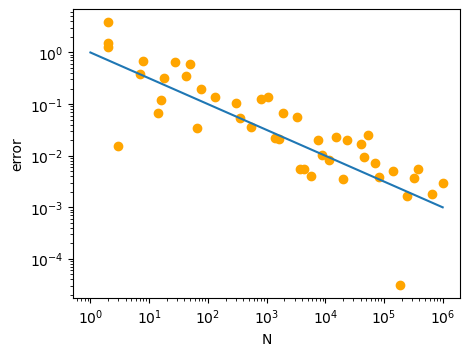

In [32]:
n = np.logspace(0,6,100,dtype=int)
error = []
for N in n:
    integral = integral_MC(N)
    error.append((integral - knownresult)/knownresult)

fig, ax = plt.subplots(figsize=(5, 3.75))

ax.scatter(n,error,c='orange')
ax.plot(n,1/np.sqrt(n))
ax.set(xscale = "log", yscale = "log",xlabel=("N"),ylabel=("error"))

plt.show()

For a given $N$, how are the result distributed? 
As gaussian? As t of student?

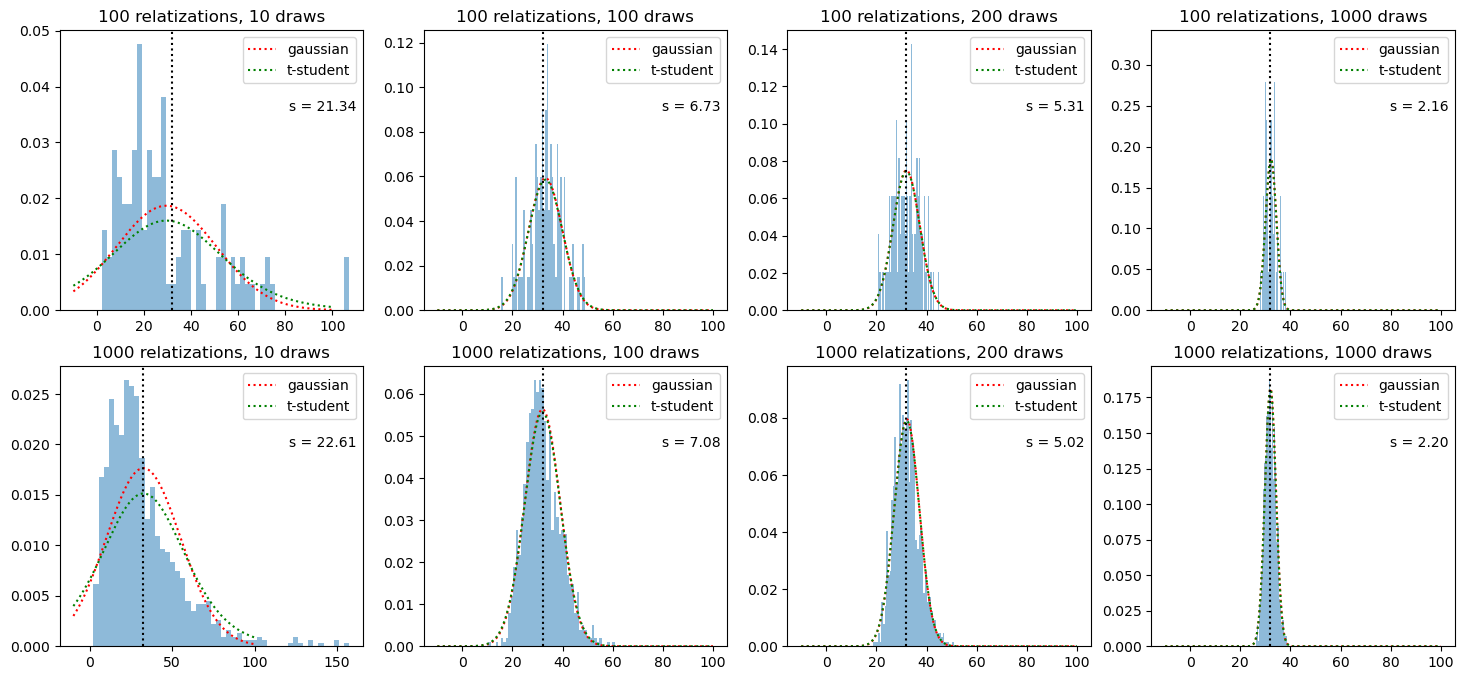

In [35]:
from scipy.stats import norm
from scipy.stats import t as student_t

fig, ax = plt.subplots(2,4,figsize=(18, 8))

for j,realizations in enumerate([100,1000]):

    for i,N in enumerate([10,100,200,1000]): 
        integrals = []
        for _ in range(realizations): 
            integrals.append(integral_MC(N))
        
        ax[j,i].hist(integrals,density=True,alpha=0.5,bins=50)
    
        mean = np.average(integrals)
        std = np.std(integrals, ddof=1)
    
    
        x = np.linspace(-10, 100, 1000)
        ax[j,i].plot(x,norm(loc=mean,scale=std).pdf(x),linestyle=':',c='red',label='gaussian')
        ax[j,i].plot(x,student_t(df=N-1, loc=mean, scale=std * np.sqrt((N-1) / (N-3))).pdf(x),linestyle=':',c='green',label='t-student')
        ax[j,i].axvline(x=knownresult,linestyle=':',c='black')
        ax[j,i].set_title(f'{realizations:.0f} relatizations, {N:.0f} draws')
        ax[j,i].text(0.98, 0.7, f"s = {std:.2f}", transform=ax[j,i].transAxes, ha='right', va='bottom')
    
        ax[j,i].legend()

plt.show()



Why is the integral underestimated for small $N$?
Common reasons:

- Bias in the MC estimator:

If your sampling distribution is not well matched to the function $f(x)$, and especially if the function has sharp features or large curvature, low-$N$ realizations may systematically miss important regions → underestimate.

- Non-zero lower limit and skewed distribution:

If your integral is over a function that is positive and increasing (or has skew), many low-$N$ draws may miss the "tail" where values are large. This leads to systematic underestimation.

- Low sample size = high variance → asymmetric effects:

When you take the mean of few samples, you’re more likely to underestimate than to hit a rare large value that would pull the average up.

